In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/COOP.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,10.20,10.32,9.48,9.72,9.72,64700
1,1/3/2013,9.60,9.84,9.48,9.60,9.60,21600
2,1/4/2013,9.48,9.96,9.48,9.48,9.48,8000
3,1/7/2013,9.48,9.60,9.00,9.36,9.36,116100
4,1/8/2013,9.48,9.48,7.80,8.40,8.40,20800


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: -75.900013.3, cost: 0.000894, total money: 9782.889987
epoch: 20, total rewards: 408.500027.3, cost: 0.000369, total money: 10383.540027
epoch: 30, total rewards: 9.250013.3, cost: 0.000105, total money: 10009.250013
epoch: 40, total rewards: 211.259970.3, cost: 0.000165, total money: 10095.899969
epoch: 50, total rewards: 13.060002.3, cost: 0.000774, total money: 9962.450001
epoch: 60, total rewards: -15.390003.3, cost: 0.000261, total money: 9946.679996
epoch: 70, total rewards: -71.380014.3, cost: 0.000040, total money: 9928.619986
epoch: 80, total rewards: 66.929989.3, cost: 0.001426, total money: 9879.959988
epoch: 90, total rewards: 62.420015.3, cost: 0.000028, total money: 10049.590015
epoch: 100, total rewards: -32.979971.3, cost: 0.000043, total money: 9967.020029
epoch: 110, t

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 14: buy 1 unit at price 10.080000, total balance 9989.920000
day 15: buy 1 unit at price 9.960000, total balance 9979.960000
day 18: buy 1 unit at price 9.240000, total balance 9970.720000
day 19: buy 1 unit at price 9.360000, total balance 9961.360001
day 20, sell 1 unit at price 9.480000, investment -5.952385 %, total balance 9970.840000,
day 21: buy 1 unit at price 9.000000, total balance 9961.840000
day 25: buy 1 unit at price 9.840000, total balance 9952.000000
day 30, sell 1 unit at price 8.880000, investment -10.843373 %, total balance 9960.880000,
day 32, sell 1 unit at price 9.600000, investment 3.896111 %, total balance 9970.480000,
day 42, sell 1 unit at price 8.640000, investment -7.692301 %, total balance 9979.120001,
day 43, sell 1 unit at price 9.000000, investment 0.000000 %, total balance 9988.120001,
day 49: buy 1 unit at price 8.760000, total balance 9979.360001
day 50, sell 1 unit at price 8.760000, investment -10.975609 %, total balance 9988.120001,
day 55, sel

day 552, sell 1 unit at price 27.840000, investment 7.906981 %, total balance 9890.320001,
day 556, sell 1 unit at price 27.959999, investment 5.909089 %, total balance 9918.280000,
day 558: buy 1 unit at price 28.440001, total balance 9889.839999
day 559, sell 1 unit at price 27.840000, investment 5.454548 %, total balance 9917.679999,
day 561, sell 1 unit at price 27.360001, investment 4.587159 %, total balance 9945.040000,
day 562, sell 1 unit at price 27.120001, investment 2.727277 %, total balance 9972.160001,
day 565: buy 1 unit at price 26.400000, total balance 9945.760001
day 572, sell 1 unit at price 29.879999, investment 5.063286 %, total balance 9975.640000,
day 573, sell 1 unit at price 29.639999, investment 12.272727 %, total balance 10005.280000,
day 576: buy 1 unit at price 29.760000, total balance 9975.520000
day 579, sell 1 unit at price 30.600000, investment 2.822581 %, total balance 10006.120000,
day 582: buy 1 unit at price 31.799999, total balance 9974.320001
day 5

day 1209: buy 1 unit at price 10.080000, total balance 9945.760000
day 1212, sell 1 unit at price 8.760000, investment -33.636361 %, total balance 9954.520000,
day 1223: buy 1 unit at price 8.520000, total balance 9946.000000
day 1224: buy 1 unit at price 8.400000, total balance 9937.600000
day 1233, sell 1 unit at price 8.640000, investment -24.210521 %, total balance 9946.240001,
day 1235, sell 1 unit at price 8.520000, investment -15.476185 %, total balance 9954.760001,
day 1238, sell 1 unit at price 10.080000, investment 18.309852 %, total balance 9964.840001,
day 1244: buy 1 unit at price 10.800000, total balance 9954.040001
day 1247, sell 1 unit at price 9.720000, investment 15.714294 %, total balance 9963.760001,
day 1249: buy 1 unit at price 8.880000, total balance 9954.880001
day 1251, sell 1 unit at price 8.640000, investment -19.999998 %, total balance 9963.520001,
day 1256: buy 1 unit at price 9.360000, total balance 9954.160002
day 1258: buy 1 unit at price 10.200000, tota

day 1640, sell 1 unit at price 7.910000, investment -35.951420 %, total balance 9832.530000,
day 1643: buy 1 unit at price 7.900000, total balance 9824.630000
day 1644, sell 1 unit at price 7.910000, investment -27.696525 %, total balance 9832.540000,
day 1647, sell 1 unit at price 7.590000, investment -15.760267 %, total balance 9840.130000,
day 1648: buy 1 unit at price 7.260000, total balance 9832.870000
day 1652, sell 1 unit at price 7.740000, investment -11.542860 %, total balance 9840.610000,
day 1654: buy 1 unit at price 7.640000, total balance 9832.970000
day 1658, sell 1 unit at price 8.860000, investment 6.875750 %, total balance 9841.829999,
day 1663: buy 1 unit at price 9.390000, total balance 9832.439999
day 1666, sell 1 unit at price 9.060000, investment 2.027030 %, total balance 9841.500000,
day 1669: buy 1 unit at price 9.540000, total balance 9831.960000
day 1672, sell 1 unit at price 9.050000, investment -5.532356 %, total balance 9841.010000,
day 1673: buy 1 unit at 

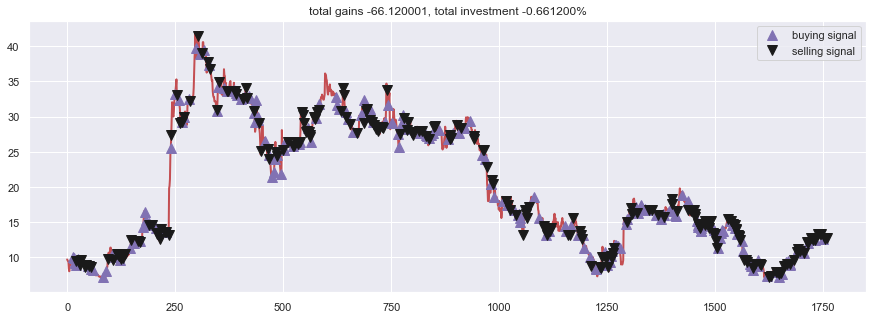

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()